<a href="https://colab.research.google.com/github/girijeshcse/car_finder/blob/nitya/notebooks/Capstone_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Step 1: Import the data

In [ ]:
%tensorflow_version 2.x
import tensorflow
tensorflow.__version__
# Initialize the random number generator
import random
random.seed(0)
# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
project_path = '/content/drive/MyDrive/Capstone/Dataset/'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
train_anno_df=pd.read_csv(project_path+'/Annotations/Train Annotations.csv')
test_anno_df=pd.read_csv(project_path+'/Annotations/Test Annotation.csv')
train_anno_df

,Image Name,Bounding Box coordinates,Unnamed: 2,Unnamed: 3,Unnamed: 4,Image class
0,00001.jpg,39,116,569,375,14
1,00002.jpg,36,116,868,587,3
2,00003.jpg,85,109,601,381,91
3,00004.jpg,621,393,1484,1096,134
4,00005.jpg,14,36,133,99,106
...,...,...,...,...,...,...
8139,08140.jpg,3,44,423,336,78
8140,08141.jpg,138,150,706,523,196
8141,08142.jpg,26,246,660,449,163
8142,08143.jpg,78,526,1489,908,112


In [ ]:
train_anno_df.rename(columns={'Bounding Box coordinates': 'x0', 'Unnamed: 2': 'y0','Unnamed: 3': 'x1','Unnamed: 4': 'y1'}, inplace=True)
train_anno_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8144 entries, 0 to 8143
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Image Name   8144 non-null   object
 1   x0           8144 non-null   int64 
 2   y0           8144 non-null   int64 
 3   x1           8144 non-null   int64 
 4   y1           8144 non-null   int64 
 5   Image class  8144 non-null   int64 
dtypes: int64(5), object(1)
memory usage: 381.9+ KB


In [ ]:
train_anno_df.head(10)

,Image Name,x0,y0,x1,y1,Image class
0,00001.jpg,39,116,569,375,14
1,00002.jpg,36,116,868,587,3
2,00003.jpg,85,109,601,381,91
3,00004.jpg,621,393,1484,1096,134
4,00005.jpg,14,36,133,99,106
5,00006.jpg,259,289,515,416,123
6,00007.jpg,88,80,541,397,89
7,00008.jpg,73,79,591,410,96
8,00009.jpg,20,126,1269,771,167
9,00010.jpg,21,110,623,367,58


In [ ]:
test_anno_df.rename(columns={'Bounding Box coordinates': 'x0', 'Unnamed: 2': 'y0','Unnamed: 3': 'x1','Unnamed: 4': 'y1'}, inplace=True)
test_anno_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8041 entries, 0 to 8040
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Image Name   8041 non-null   object
 1   x0           8041 non-null   int64 
 2   y0           8041 non-null   int64 
 3   x1           8041 non-null   int64 
 4   y1           8041 non-null   int64 
 5   Image class  8041 non-null   int64 
dtypes: int64(5), object(1)
memory usage: 377.0+ KB


In [ ]:
test_anno_df.head(10)

,Image Name,x0,y0,x1,y1,Image class
0,00001.jpg,30,52,246,147,181
1,00002.jpg,100,19,576,203,103
2,00003.jpg,51,105,968,659,145
3,00004.jpg,67,84,581,407,187
4,00005.jpg,140,151,593,339,185
5,00006.jpg,20,77,420,301,78
6,00007.jpg,249,166,2324,1459,118
7,00008.jpg,119,215,1153,719,165
8,00009.jpg,1,7,275,183,32
9,00010.jpg,28,55,241,177,60


Step 2: Map training and testing images to its classes.

In [ ]:
#Loading name of cars 
carNameDF= pd.read_csv(project_path+'Car names and make.csv',header=None)
carNameDF.shape

(196, 1)

In [ ]:
carNameDF.head(10)

,0
0,AM General Hummer SUV 2000
1,Acura RL Sedan 2012
2,Acura TL Sedan 2012
3,Acura TL Type-S 2008
4,Acura TSX Sedan 2012
5,Acura Integra Type R 2001
6,Acura ZDX Hatchback 2012
7,Aston Martin V8 Vantage Convertible 2012
8,Aston Martin V8 Vantage Coupe 2012
9,Aston Martin Virage Convertible 2012


In [ ]:
carNameDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196 entries, 0 to 195
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       196 non-null    object
dtypes: object(1)
memory usage: 1.7+ KB


Function to create data frame with Image Name,Image np array,Car Make

In [ ]:
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
CHANNEL=3

In [ ]:
import os
import tensorflow
from keras.preprocessing import image
#from tqdm import tqdm
def createImageDF(imageSourceFolder,target_size_tuple,colormode,totalImagePerClassCap):
    dfRows=[]
    for dirname, _, filenames in os.walk(imageSourceFolder):
            limit=0
            if len(filenames) < totalImagePerClassCap or totalImagePerClassCap == 0:
                limit=len(filenames)
            else:
                limit=totalImagePerClassCap
            for i in range(0,limit):
                    processedRows=[]
                    filename=filenames[i]
                    processedRows.append(filename)
                    pathSplits=dirname.split('/')
                    #print(os.path.join(dirname, filename))
                    imgPath=os.path.join(dirname, filename)
                    #print(imgPath)
                    img = image.load_img(imgPath)
                    if target_size_tuple!='':
                        img_scaled = image.load_img(imgPath, target_size=target_size_tuple, color_mode = colormode)
                        image_width_scale_fact=target_size_tuple[0]/img.width
                        image_height_scale_fact=target_size_tuple[1]/img.height
                        imgArray = image.img_to_array(img_scaled)
                    else:
                        img
                        image_width_scale_fact=img.width
                        image_height_scale_fact=img.height
                        #img = Image.open(imgPath)
                        imgArray = image.img_to_array(img)
                    #imgArray=np.asarray(img)
                    processedRows.append(imgArray)
                    processedRows.append(pathSplits[len(pathSplits)-1])
                    processedRows.append(image_width_scale_fact)
                    processedRows.append(image_height_scale_fact)
                    dfRows.append(processedRows)
    return pd.DataFrame(dfRows, columns=["Image Name","image_array","model","image_width_scale_fact","image_height_scale_fact"])

In [ ]:
def loadSingleScoringImage(imageSourcePath,target_size_tuple,colormode):
    dfRows=[]
    processedRow=[]
    imgPath=imageSourcePath
    img = image.load_img(imgPath)
    pathSplits=imgPath.split('/')
    if target_size_tuple!='':
        img_scaled = image.load_img(imgPath, target_size=target_size_tuple, color_mode = colormode)
        image_width_scale_fact=target_size_tuple[0]/img.width
        image_height_scale_fact=target_size_tuple[1]/img.height
        imgArray = image.img_to_array(img_scaled)
    else:
        img
        image_width_scale_fact=img.width
        image_height_scale_fact=img.height
        #img = Image.open(imgPath)
        imgArray = image.img_to_array(img)
    #imgArray=np.asarray(img)
    processedRow.append(pathSplits[len(pathSplits)-1])
    processedRow.append(imgArray)
    processedRow.append(pathSplits[len(pathSplits)-2])
    processedRow.append(image_width_scale_fact)
    processedRow.append(image_height_scale_fact)
    dfRows.append(processedRow)
    return pd.DataFrame(dfRows, columns=["Image Name","image_array","model","image_width_scale_fact","image_height_scale_fact"])

In [ ]:
trainImageDF=createImageDF('/content/drive/MyDrive/Capstone/Dataset/CarImages/TrainImages','',"rgb",2)
trainImageDF

,Image Name,image_array,model,image_width_scale_fact,image_height_scale_fact


In [ ]:
trainImageDF.head(10)

,Image Name,image_array,model,image_width_scale_fact,image_height_scale_fact


In [ ]:
# Lodaing annotation details for images from train_anno_df i.e. train annotations
trainMergedImageDF=pd.merge(trainImageDF,train_anno_df, on=['Image Name'])

In [ ]:
trainMergedImageDF.head(10)

,image_array,model,image_width_scale_fact,image_height_scale_fact,Image Name,x0,y0,x1,y1,Image class


In [ ]:
len(trainMergedImageDF)

0

Function to create bounding box on image

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def drowBoxedImages(dataFrame,featureCol,x0,y0,x1,y1,boxlinewidth,boxedgecolor):
  fig,ax=plt.subplots(len(dataFrame))
  fig.set_size_inches(15,15)
  # Display the image
  for index, row in dataFrame.iterrows():
    data=row[featureCol]
    img = image.array_to_img(data)
    ax[index].imshow(img)
    image_height, image_width, _ = data.shape
    rect=[]
    rect.append(patches.Rectangle((row[x0], row[y0]), row[x1] - row[x0], row[y1] - row[y0], linewidth=boxlinewidth, edgecolor=boxedgecolor, facecolor='none'))
    # Add the patch to the Axes
    for l in range(0,len(rect)):
      ax[index].add_patch(rect[l])
  plt.show()

In [ ]:
def drowImages(dataFrame,featureCol):
  fig,ax=plt.subplots(len(dataFrame))
  fig.set_size_inches(15,15)
  # Display the image
  for index, row in dataFrame.iterrows():
    data=row[featureCol]
    img = image.array_to_img(data)
    ax[index].imshow(img)
  plt.show()

In [ ]:
drowBoxedImages(trainMergedImageDF.head(10),'image_array','x0','y0','x1','y1',2,'r')

<Figure size 1080x1080 with 0 Axes>

In [ ]:
testImageDF=createImageDF('project_path+Car Images/Test Images/','',"rgb",2)

In [ ]:
testImageDF.head(10)

,Image Name,image_array,model,image_width_scale_fact,image_height_scale_fact


In [ ]:
# Lodaing annotation details for images from train_anno_df i.e. train annotations
testMergedImageDF=pd.merge(testImageDF,test_anno_df, on=['Image Name'])

In [ ]:
testMergedImageDF.head(10)

,image_array,model,image_width_scale_fact,image_height_scale_fact,Image Name,x0,y0,x1,y1,Image class


In [ ]:
drowBoxedImages(testMergedImageDF.head(10),'image_array','x0','y0','x1','y1',2,'r')

<Figure size 1080x1080 with 0 Axes>

check distribution of each class in our training data

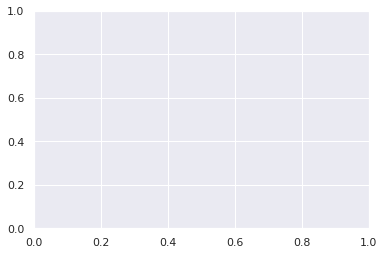

In [ ]:
import seaborn as sns
sns.set_theme(style="darkgrid")
sns.histplot(x= trainMergedImageDF['Image class'],bins = 20)

In [ ]:
#trainReducedImageDF=createImageDF('../input/stanford-car-dataset-by-classes-folder/car_data/car_data/train',(IMAGE_WIDTH,IMAGE_HEIGHT,CHANNEL),"rgb",5)